<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Base_CNN_(5_labels)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# -*- coding: utf-8 -*-
"""
1D CNN for Tabular Production Classification - Step by Step Execution

This script loads tabular data, preprocesses it (including reshaping for CNN),
trains a 1D Convolutional Neural Network (CNN),
evaluates its performance using Confusion Matrix, Classification Report, and Macro F1 Score,
and plots the training history interactively.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific warnings from sklearn
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.metrics._classification')

In [19]:
# =====================================================================
# STEP 1: CONFIGURATION AND SETUP
# =====================================================================
print("="*70)
print("STEP 1: CONFIGURATION AND SETUP")
print("="*70)

# Configuration parameters
TRAIN_FILE = '/content/drive/MyDrive/UpdatedDataset/train.csv'
VALIDATION_FILE = '/content/drive/MyDrive/UpdatedDataset/validation.csv'
TEST_FILE = '/content/drive/MyDrive/UpdatedDataset/test.csv'
TARGET_COLUMN = 'Production (M.Ton)'
INITIAL_N_CLASSES = 5  # Desired number of classes for binning
CLASS_LABELS = ['very low', 'low', 'medium', 'high', 'very high']  # Corresponding to bins 0-4
EPOCHS = 100  # Increased epochs to match the example plot
BATCH_SIZE = 64
RANDOM_STATE = 42  # For reproducibility

# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print(f"Configuration loaded:")
print(f"- Target Column: {TARGET_COLUMN}")
print(f"- Number of Classes: {INITIAL_N_CLASSES}")
print(f"- Class Labels: {CLASS_LABELS}")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Random State: {RANDOM_STATE}")
print("Configuration completed successfully!\n")

STEP 1: CONFIGURATION AND SETUP
Configuration loaded:
- Target Column: Production (M.Ton)
- Number of Classes: 5
- Class Labels: ['very low', 'low', 'medium', 'high', 'very high']
- Epochs: 100
- Batch Size: 64
- Random State: 42
Configuration completed successfully!



In [20]:
# =====================================================================
# STEP 2: DEFINE DATA LOADING FUNCTION
# =====================================================================
print("="*70)
print("STEP 2: DEFINE DATA LOADING FUNCTION")
print("="*70)

def load_data(file_path):
    """Loads data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {file_path}. Shape: {df.shape}")
        if TARGET_COLUMN not in df.columns:
            raise ValueError(f"Target column '{TARGET_COLUMN}' not found in {file_path}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please update the file path.")
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

print("Data loading function defined successfully!\n")

STEP 2: DEFINE DATA LOADING FUNCTION
Data loading function defined successfully!



In [21]:
# =====================================================================
# STEP 3: DEFINE PREPROCESSING FUNCTION
# =====================================================================
print("="*70)
print("STEP 3: DEFINE PREPROCESSING FUNCTION")
print("="*70)

def preprocess_data_cnn(df_train, df_val, df_test, n_classes_target):
    """Preprocesses the training, validation, and test data for 1D CNN.

    Returns:
        Tuple containing preprocessed data and the actual number of classes used.
    """
    print("\n--- Starting Data Preprocessing for CNN ---")

    X_train = df_train.drop(TARGET_COLUMN, axis=1)
    y_train_raw = df_train[TARGET_COLUMN]
    X_val = df_val.drop(TARGET_COLUMN, axis=1)
    y_val_raw = df_val[TARGET_COLUMN]
    X_test = df_test.drop(TARGET_COLUMN, axis=1)
    y_test_raw = df_test[TARGET_COLUMN]

    train_cols = X_train.columns
    X_val = X_val.reindex(columns=train_cols, fill_value=0)
    X_test = X_test.reindex(columns=train_cols, fill_value=0)

    print(f"Initial feature shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

    actual_n_classes = n_classes_target
    print(f"Attempting to bin target variable '{TARGET_COLUMN}' into {n_classes_target} categories...")
    try:
        bins = pd.qcut(y_train_raw, q=n_classes_target, labels=False, duplicates='drop')
        bin_edges = pd.qcut(y_train_raw, q=n_classes_target, retbins=True, duplicates='drop')[1]
        print(f"Calculated bin edges based on training data: {bin_edges}")

        y_train_binned = pd.cut(y_train_raw, bins=bin_edges, labels=False, include_lowest=True)
        y_val_binned = pd.cut(y_val_raw, bins=bin_edges, labels=False, include_lowest=True)
        y_test_binned = pd.cut(y_test_raw, bins=bin_edges, labels=False, include_lowest=True)

        # Handle potential NaNs introduced by pd.cut if values fall outside bins
        y_val_binned.fillna(0, inplace=True)  # Fill NaNs, e.g., with the lowest class
        y_test_binned.fillna(0, inplace=True)
        y_val_binned = y_val_binned.astype(int)
        y_test_binned = y_test_binned.astype(int)

        print("Target variable distribution after binning (Train):")
        print(y_train_binned.value_counts(normalize=True).sort_index())
        actual_n_classes = y_train_binned.nunique()
        if actual_n_classes != n_classes_target:
            print(f"Warning: Binning resulted in {actual_n_classes} classes, not the target {n_classes_target}.")

    except ValueError as e:
        print(f"Error during quantile binning: {e}. Falling back to LabelEncoder.")
        encoder = LabelEncoder()
        y_train_binned = encoder.fit_transform(y_train_raw)
        y_val_binned = encoder.transform(y_val_raw)
        y_test_binned = encoder.transform(y_test_raw)
        actual_n_classes = len(encoder.classes_)
        print(f"Using LabelEncoder resulted in {actual_n_classes} classes.")

    print(f"Final number of classes used for encoding: {actual_n_classes}")

    print("One-hot encoding target variable...")
    y_train_encoded = to_categorical(y_train_binned, num_classes=actual_n_classes)
    y_val_encoded = to_categorical(y_val_binned, num_classes=actual_n_classes)
    y_test_encoded = to_categorical(y_test_binned, num_classes=actual_n_classes)

    print("Scaling numerical features...")
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    print(f"Identified {len(numerical_cols)} numerical columns for scaling.")

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    print("Features scaled using StandardScaler.")

    # Reshape data for 1D CNN: (n_samples, n_features, 1 channel)
    print("Reshaping features for 1D CNN...")
    X_train_reshaped = X_train_scaled.values.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_val_reshaped = X_val_scaled.values.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
    X_test_reshaped = X_test_scaled.values.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    print(f"Reshaped feature shapes: Train={X_train_reshaped.shape}, Val={X_val_reshaped.shape}, Test={X_test_reshaped.shape}")

    print("--- Data Preprocessing Finished ---")
    return X_train_reshaped, y_train_encoded, y_train_binned, \
           X_val_reshaped, y_val_encoded, y_val_binned, \
           X_test_reshaped, y_test_encoded, y_test_binned, actual_n_classes

print("Data preprocessing function defined successfully!\n")

STEP 3: DEFINE PREPROCESSING FUNCTION
Data preprocessing function defined successfully!



In [22]:
# =====================================================================
# STEP 4: DEFINE MODEL BUILDING FUNCTION
# =====================================================================
print("="*70)
print("STEP 4: DEFINE MODEL BUILDING FUNCTION")
print("="*70)

def build_cnn_model(input_shape, num_classes):
    """Builds a simple 1D CNN model."""
    model = Sequential([
        InputLayer(input_shape=input_shape),  # Shape: (n_features, 1)
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("\n--- Model Summary ---")
    model.summary()
    return model

print("Model building function defined successfully!\n")

STEP 4: DEFINE MODEL BUILDING FUNCTION
Model building function defined successfully!



In [23]:
# =====================================================================
# STEP 5: DEFINE EVALUATION METRICS FUNCTION
# =====================================================================
print("="*70)
print("STEP 5: DEFINE EVALUATION METRICS FUNCTION")
print("="*70)

def print_comprehensive_evaluation_metrics(y_true, y_pred_classes, num_classes_actual, class_labels_config, dataset_name="Dataset"):
    """Calculates and prints comprehensive evaluation metrics including Classification Report and Confusion Matrix."""
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE EVALUATION METRICS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Basic accuracy metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    macro_f1 = f1_score(y_true, y_pred_classes, average='macro', zero_division=0)
    micro_f1 = f1_score(y_true, y_pred_classes, average='micro', zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred_classes, average='weighted', zero_division=0)

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")

    # Determine labels for the reports
    labels_to_use = None
    unique_labels_in_data = sorted(np.unique(y_true))

    if len(class_labels_config) == num_classes_actual and len(unique_labels_in_data) == num_classes_actual:
        try:
            labels_to_use = [class_labels_config[i] for i in unique_labels_in_data]
            target_names = labels_to_use
        except IndexError:
            print(f"Warning: Index error mapping class labels. Using numerical labels.")
            labels_to_use = [str(label) for label in unique_labels_in_data]
            target_names = labels_to_use
    else:
        labels_to_use = [str(label) for label in unique_labels_in_data]
        target_names = labels_to_use
        print(f"Warning: Class label mismatch or inconsistency. Using numerical labels: {labels_to_use}")

    # Classification Report
    print(f"\n{'-'*50}")
    print("DETAILED CLASSIFICATION REPORT")
    print(f"{'-'*50}")

    try:
        class_report = classification_report(
            y_true,
            y_pred_classes,
            target_names=target_names,
            zero_division=0,
            digits=4
        )
        print(class_report)

        # Save classification report to file
        with open(f"classification_report_{dataset_name.lower().replace(' ', '_')}.txt", 'w') as f:
            f.write(f"Classification Report for {dataset_name}\n")
            f.write("="*50 + "\n")
            f.write(f"Overall Accuracy: {accuracy:.4f}\n")
            f.write(f"Macro F1 Score: {macro_f1:.4f}\n")
            f.write(f"Micro F1 Score: {micro_f1:.4f}\n")
            f.write(f"Weighted F1 Score: {weighted_f1:.4f}\n\n")
            f.write("Detailed Per-Class Metrics:\n")
            f.write("-"*30 + "\n")
            f.write(class_report)

        print(f"Classification report saved to: classification_report_{dataset_name.lower().replace(' ', '_')}.txt")

    except Exception as e:
        print(f"Error generating classification report: {e}")

    cm = confusion_matrix(y_true, y_pred_classes)

    # Calculate and print per-class metrics from confusion matrix
    print(f"\nPer-Class Analysis from Confusion Matrix:")
    print(f"{'Class':<15} {'True Pos':<10} {'False Pos':<10} {'False Neg':<10} {'Precision':<10} {'Recall':<10}")
    print("-" * 70)

    for i, label in enumerate(labels_to_use):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"{label:<15} {tp:<10} {fp:<10} {fn:<10} {precision:<10.4f} {recall:<10.4f}")

    # Plot confusion matrix
    try:
        plt.figure(figsize=(6, 4))

        # Create heatmap
        sns.heatmap(cm,
                   annot=True,
                   fmt="d",
                   cmap="Blues",
                   xticklabels=labels_to_use,
                   yticklabels=labels_to_use,
                   cbar_kws={'label': 'Count'})

        plt.xlabel('Predicted Label', fontsize=10)
        plt.ylabel('True Label', fontsize=10)
        plt.title(f'Confusion Matrix - {dataset_name}', fontsize=12, fontweight='bold')

        # Add accuracy text
        plt.figtext(0.02, 0.02, f'Overall Accuracy: {accuracy:.4f}', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

        plt.tight_layout()
        plt.show()  # Display the plot interactively
        plt.close()

    except Exception as e:
        print(f"Could not plot confusion matrix: {e}")

    # Summary statistics
    print(f"\n{'-'*50}")
    print("SUMMARY STATISTICS")
    print(f"{'-'*50}")
    print(f"Total Samples: {len(y_true)}")
    print(f"Number of Classes: {num_classes_actual}")
    print(f"Class Distribution:")
    class_counts = pd.Series(y_true).value_counts().sort_index()
    for i, count in class_counts.items():
        label = labels_to_use[i] if i < len(labels_to_use) else str(i)
        percentage = (count / len(y_true)) * 100
        print(f"  {label}: {count} samples ({percentage:.2f}%)")

    print(f"\n{'='*60}")

print("Evaluation metrics function defined successfully!\n")

STEP 5: DEFINE EVALUATION METRICS FUNCTION
Evaluation metrics function defined successfully!



In [24]:
# =====================================================================
# STEP 6: DEFINE TRAINING HISTORY PLOTTING FUNCTION
# =====================================================================
print("="*70)
print("STEP 6: DEFINE TRAINING HISTORY PLOTTING FUNCTION")
print("="*70)

def plot_training_history(history, epochs):
    """Plots the training and validation accuracy and loss."""
    # Check if history object contains the required keys
    required_keys = ["accuracy", "val_accuracy", "loss", "val_loss"]
    if not all(key in history.history for key in required_keys):
        print("Error: History object missing required keys for plotting.")
        print(f"Available keys: {list(history.history.keys())}")
        return

    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    # Ensure the number of epochs matches the data length
    actual_epochs = len(acc)
    if actual_epochs != epochs:
        print(f"Warning: Specified epochs ({epochs}) differs from actual epochs in history ({actual_epochs}). Using actual epochs for plotting.")
        epochs_range = range(actual_epochs)
    else:
        epochs_range = range(epochs)

    plt.figure(figsize=(15, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-', label="Training Accuracy", linewidth=2)
    plt.plot(epochs_range, val_acc, 'r-', label="Validation Accuracy", linewidth=2)
    plt.legend(loc="best")
    plt.title("Model Accuracy Over Epochs", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add final accuracy values as text
    final_train_acc = acc[-1]
    final_val_acc = val_acc[-1]
    plt.text(0.02, 0.95, f'Final Train Acc: {final_train_acc:.4f}',
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    plt.text(0.02, 0.88, f'Final Val Acc: {final_val_acc:.4f}',
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-', label="Training Loss", linewidth=2)
    plt.plot(epochs_range, val_loss, 'r-', label="Validation Loss", linewidth=2)
    plt.legend(loc="best")
    plt.title("Model Loss Over Epochs", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add final loss values as text
    final_train_loss = loss[-1]
    final_val_loss = val_loss[-1]
    plt.text(0.02, 0.95, f'Final Train Loss: {final_train_loss:.4f}',
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    plt.text(0.02, 0.88, f'Final Val Loss: {final_val_loss:.4f}',
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

    plt.tight_layout()
    plt.show()  # Display the plot interactively
    print("\nTraining history plot displayed.")

print("Training history plotting function defined successfully!\n")

STEP 6: DEFINE TRAINING HISTORY PLOTTING FUNCTION
Training history plotting function defined successfully!



In [25]:
# =====================================================================
# STEP 7: LOAD TRAINING DATA
# =====================================================================
print("="*70)
print("STEP 7: LOAD TRAINING DATA")
print("="*70)

df_train = load_data(TRAIN_FILE)
if df_train is None:
    print("Error loading training data. Please check file path and integrity. Exiting.")
    exit()

print(f"Training data loaded successfully!")
print(f"Training data shape: {df_train.shape}")
print(f"Training data columns: {list(df_train.columns)}")
print(f"Target column '{TARGET_COLUMN}' statistics:")
print(df_train[TARGET_COLUMN].describe())
print()

STEP 7: LOAD TRAINING DATA
Successfully loaded /content/drive/MyDrive/UpdatedDataset/train.csv. Shape: (3942, 84)
Training data loaded successfully!
Training data shape: (3942, 84)
Training data columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dhaka', 'Distr

In [26]:
# =====================================================================
# STEP 8: LOAD VALIDATION DATA
# =====================================================================
print("="*70)
print("STEP 8: LOAD VALIDATION DATA")
print("="*70)

df_val = load_data(VALIDATION_FILE)
if df_val is None:
    print("Error loading validation data. Please check file path and integrity. Exiting.")
    exit()

print(f"Validation data loaded successfully!")
print(f"Validation data shape: {df_val.shape}")
print(f"Validation data columns: {list(df_val.columns)}")
print(f"Target column '{TARGET_COLUMN}' statistics:")
print(df_val[TARGET_COLUMN].describe())
print()

STEP 8: LOAD VALIDATION DATA
Successfully loaded /content/drive/MyDrive/UpdatedDataset/validation.csv. Shape: (845, 84)
Validation data loaded successfully!
Validation data shape: (845, 84)
Validation data columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dha

In [27]:


# =====================================================================
# STEP 9: LOAD TEST DATA
# =====================================================================
print("="*70)
print("STEP 9: LOAD TEST DATA")
print("="*70)

df_test = load_data(TEST_FILE)
if df_test is None:
    print("Error loading test data. Please check file path and integrity. Exiting.")
    exit()

print(f"Test data loaded successfully!")
print(f"Test data shape: {df_test.shape}")
print(f"Test data columns: {list(df_test.columns)}")
print(f"Target column '{TARGET_COLUMN}' statistics:")
print(df_test[TARGET_COLUMN].describe())
print()

STEP 9: LOAD TEST DATA
Successfully loaded /content/drive/MyDrive/UpdatedDataset/test.csv. Shape: (845, 84)
Test data loaded successfully!
Test data shape: (845, 84)
Test data columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dhaka', 'District_Dinajpur', 'Dis

In [28]:
# =====================================================================
# STEP 10: PREPROCESS DATA FOR CNN
# =====================================================================
print("="*70)
print("STEP 10: PREPROCESS DATA FOR CNN")
print("="*70)

X_train_reshaped, y_train_encoded, y_train_binned, \
X_val_reshaped, y_val_encoded, y_val_binned, \
X_test_reshaped, y_test_encoded, y_test_binned, actual_n_classes = preprocess_data_cnn(df_train, df_val, df_test, INITIAL_N_CLASSES)

if X_train_reshaped is None:
    print("Error during preprocessing. Exiting.")
    exit()

print(f"Data preprocessing completed successfully!")
print(f"Final shapes:")
print(f"- X_train_reshaped: {X_train_reshaped.shape}")
print(f"- X_val_reshaped: {X_val_reshaped.shape}")
print(f"- X_test_reshaped: {X_test_reshaped.shape}")
print(f"- y_train_encoded: {y_train_encoded.shape}")
print(f"- y_val_encoded: {y_val_encoded.shape}")
print(f"- y_test_encoded: {y_test_encoded.shape}")
print(f"- Actual number of classes: {actual_n_classes}")
print()

STEP 10: PREPROCESS DATA FOR CNN

--- Starting Data Preprocessing for CNN ---
Initial feature shapes: Train=(3942, 83), Val=(845, 83), Test=(845, 83)
Attempting to bin target variable 'Production (M.Ton)' into 5 categories...
Calculated bin edges based on training data: [     0.       578.      1463.      3119.524   6540.92  544979.5  ]
Target variable distribution after binning (Train):
Production (M.Ton)
0    0.201167
1    0.199391
2    0.199391
3    0.199899
4    0.200152
Name: proportion, dtype: float64
Final number of classes used for encoding: 5
One-hot encoding target variable...
Scaling numerical features...
Identified 83 numerical columns for scaling.
Features scaled using StandardScaler.
Reshaping features for 1D CNN...
Reshaped feature shapes: Train=(3942, 83, 1), Val=(845, 83, 1), Test=(845, 83, 1)
--- Data Preprocessing Finished ---
Data preprocessing completed successfully!
Final shapes:
- X_train_reshaped: (3942, 83, 1)
- X_val_reshaped: (845, 83, 1)
- X_test_reshaped: (

In [29]:
# =====================================================================
# STEP 11: BUILD CNN MODEL
# =====================================================================
print("="*70)
print("STEP 11: BUILD CNN MODEL")
print("="*70)

# CNN input shape is (num_features, 1 channel)
input_shape_cnn = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
print(f"CNN input shape: {input_shape_cnn}")

model = build_cnn_model(input_shape_cnn, actual_n_classes)
print(f"CNN model built successfully with input shape {input_shape_cnn} and {actual_n_classes} output classes!")
print()

STEP 11: BUILD CNN MODEL
CNN input shape: (83, 1)

--- Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 83, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 41, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 41, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       128,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,941 (527.11 KB)

 Trainable params: 134,941 (527.11 KB)

 Non-trainable params: 0 (0.00 B)

CNN model built successfully with input shape (83, 1) and 5 output classes!



In [30]:
# =====================================================================
# STEP 12: TRAIN THE MODEL
# =====================================================================
print("="*70)
print("STEP 12: TRAIN THE MODEL")
print("="*70)

print(f"Starting model training for {EPOCHS} epochs with batch size {BATCH_SIZE}...")

# Check if data exists before training
if X_train_reshaped.size == 0 or y_train_encoded.size == 0:
    print("Error: Training data is empty. Cannot train model. Exiting.")
    exit()

history = model.fit(
    X_train_reshaped,
    y_train_encoded,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_reshaped, y_val_encoded),
    verbose=1  # Show progress
)

print("Model training completed successfully!")
print()

STEP 12: TRAIN THE MODEL
Starting model training for 100 epochs with batch size 64...
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2861 - loss: 1.5386 - val_accuracy: 0.4911 - val_loss: 1.2627
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4881 - loss: 1.2450 - val_accuracy: 0.5538 - val_loss: 1.1162
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5530 - loss: 1.1005 - val_accuracy: 0.5917 - val_loss: 1.0458
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5910 - loss: 0.9973 - val_accuracy: 0.6237 - val_loss: 0.9796
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6232 - loss: 0.9311 - val_accuracy: 0.6627 - val_loss: 0.9252
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6458 - loss: 0.8695 - val_accuracy: 0.6994 - val_loss: 0.8706
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6693 - loss: 0.8012 - val_accuracy: 0.7124 - val_loss: 0.8459
Epoch 8/100
62/62 

STEP 13: PLOT TRAINING HISTORY
Generating training history plots...


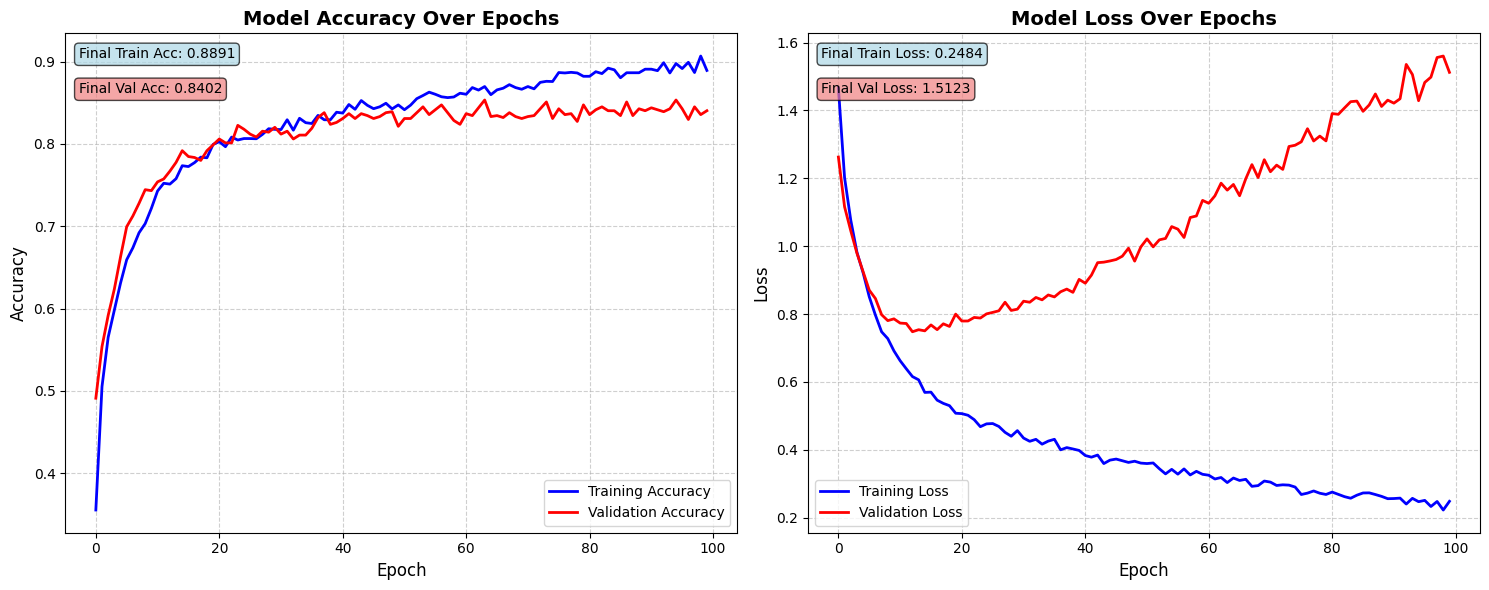


Training history plot displayed.
Training history visualization completed!



In [31]:
# =====================================================================
# STEP 13: PLOT TRAINING HISTORY
# =====================================================================
print("="*70)
print("STEP 13: PLOT TRAINING HISTORY")
print("="*70)

print("Generating training history plots...")
plot_training_history(history, EPOCHS)
print("Training history visualization completed!")
print()

STEP 14: EVALUATE ON VALIDATION SET
Evaluating model performance on validation set...
Validation Loss: 1.5123
Validation Accuracy: 0.8402
Generating predictions for validation set...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Comprehensive evaluation metrics for validation set:

COMPREHENSIVE EVALUATION METRICS FOR VALIDATION SET
Overall Accuracy: 0.8402
Macro F1 Score: 0.8372
Micro F1 Score: 0.8402
Weighted F1 Score: 0.8395

--------------------------------------------------
DETAILED CLASSIFICATION REPORT
--------------------------------------------------
              precision    recall  f1-score   support

    very low     0.9206    0.9305    0.9255       187
         low     0.7632    0.8286    0.7945       140
      medium     0.8562    0.7173    0.7806       191
        high     0.7602    0.8125    0.7855       160
   very high     0.8844    0.9162    0.9000       167

    accuracy                         0.8402       845
   macro avg     0.8369    0.8410    0.8372       845
weighte

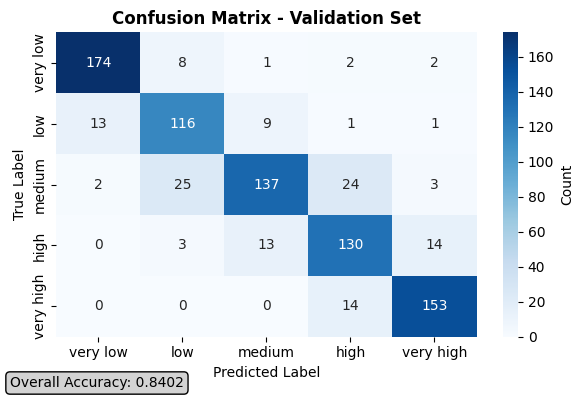


--------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------
Total Samples: 845
Number of Classes: 5
Class Distribution:
  very low: 187 samples (22.13%)
  low: 140 samples (16.57%)
  medium: 191 samples (22.60%)
  high: 160 samples (18.93%)
  very high: 167 samples (19.76%)




In [32]:
# =====================================================================
# STEP 14: EVALUATE ON VALIDATION SET
# =====================================================================
print("="*70)
print("STEP 14: EVALUATE ON VALIDATION SET")
print("="*70)

print("Evaluating model performance on validation set...")
val_loss, val_accuracy = model.evaluate(X_val_reshaped, y_val_encoded, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("Generating predictions for validation set...")
y_val_pred_probs = model.predict(X_val_reshaped)
y_val_pred_classes = np.argmax(y_val_pred_probs, axis=1)

print("Comprehensive evaluation metrics for validation set:")
print_comprehensive_evaluation_metrics(y_val_binned, y_val_pred_classes, actual_n_classes, CLASS_LABELS, dataset_name="Validation Set")
print()

STEP 15: EVALUATE ON TEST SET
Evaluating model performance on test set...
Test Loss: 0.5884
Test Accuracy: 0.8509
Generating predictions for test set...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Comprehensive evaluation metrics for test set:

COMPREHENSIVE EVALUATION METRICS FOR TEST SET
Overall Accuracy: 0.8509
Macro F1 Score: 0.8507
Micro F1 Score: 0.8509
Weighted F1 Score: 0.8517

--------------------------------------------------
DETAILED CLASSIFICATION REPORT
--------------------------------------------------
              precision    recall  f1-score   support

    very low     0.9222    0.8953    0.9086       172
         low     0.7791    0.8481    0.8121       158
      medium     0.8182    0.7545    0.7850       167
        high     0.7876    0.8686    0.8261       175
   very high     0.9623    0.8844    0.9217       173

    accuracy                         0.8509       845
   macro avg     0.8538    0.8502    0.8507       845
weighted avg     0.8552    0.8509    0.8517      

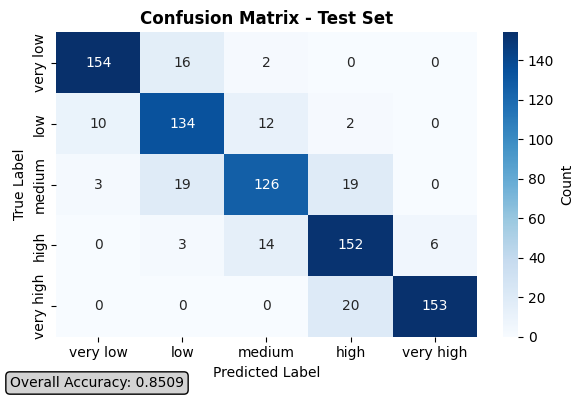


--------------------------------------------------
SUMMARY STATISTICS
--------------------------------------------------
Total Samples: 845
Number of Classes: 5
Class Distribution:
  very low: 172 samples (20.36%)
  low: 158 samples (18.70%)
  medium: 167 samples (19.76%)
  high: 175 samples (20.71%)
  very high: 173 samples (20.47%)




In [33]:
# =====================================================================
# STEP 15: EVALUATE ON TEST SET
# =====================================================================
print("="*70)
print("STEP 15: EVALUATE ON TEST SET")
print("="*70)

print("Evaluating model performance on test set...")
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("Generating predictions for test set...")
y_test_pred_probs = model.predict(X_test_reshaped)
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

print("Comprehensive evaluation metrics for test set:")
print_comprehensive_evaluation_metrics(y_test_binned, y_test_pred_classes, actual_n_classes, CLASS_LABELS, dataset_name="Test Set")
print()


In [34]:

# =====================================================================
# STEP 16: FINAL SUMMARY
# =====================================================================
print("="*70)
print("STEP 16: FINAL SUMMARY")
print("="*70)

print("PRODUCTION CLASSIFICATION TASK COMPLETED SUCCESSFULLY")
print("="*60)
print("Generated Files:")
print("- classification_report_validation_set.txt")
print("- classification_report_test_set.txt")
print("\nAll plots displayed interactively in your environment.")
print("="*60)

print("\nFinal Model Performance Summary:")
print(f"- Validation Accuracy: {val_accuracy:.4f}")
print(f"- Test Accuracy: {test_accuracy:.4f}")
print(f"- Validation Loss: {val_loss:.4f}")
print(f"- Test Loss: {test_loss:.4f}")
print(f"- Number of Classes: {actual_n_classes}")
print(f"- Training Epochs: {EPOCHS}")
print(f"- Model Architecture: 1D CNN with Conv1D layers")

print("\n" + "="*70)
print("ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*70)

STEP 16: FINAL SUMMARY
PRODUCTION CLASSIFICATION TASK COMPLETED SUCCESSFULLY
Generated Files:
- classification_report_validation_set.txt
- classification_report_test_set.txt

All plots displayed interactively in your environment.

Final Model Performance Summary:
- Validation Accuracy: 0.8402
- Test Accuracy: 0.8509
- Validation Loss: 1.5123
- Test Loss: 0.5884
- Number of Classes: 5
- Training Epochs: 100
- Model Architecture: 1D CNN with Conv1D layers

ALL STEPS COMPLETED SUCCESSFULLY!
